In [7]:
from utilities import HedgingEnv_Continuous, episodes_50_return_continuous, bs_call, delta, HedgingEnv_Discrete, episodes_50_return_discrete

import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
import torch

In [2]:
'''setting random seed'''
random.seed(24)

1. Traning for Dueling DQN

In [3]:
''' import ddgn agent'''
from duelDQN import DDQN_Agent
ddqn_agent = DDQN_Agent(state_dims = 2, action_dims = 101, lr = 0.0005, tau = 0.001)

In [4]:

S = 50
K = 50
T = 12/50 
sigma = 0.1
rf = 0

In [5]:
trial_scores_ddqn = []
best_trial_50 = -99999

for i in range(15000):
    env = HedgingEnv_Discrete(S, K, T, sigma, rf)
    done = False
    
    
    
    score = 0
    state = [S, T]
    while not done:
        action = ddqn_agent.choose_action(state)
        next_state, reward, done = env.step(action)
        ddqn_agent.store_transition(state, action, reward, next_state, int(done) )
        ddqn_agent.learn()
            #learn_iters += 1
        score += reward
        state = next_state
    
    if i % 100 == 0:
        trial_50 = episodes_50_return_discrete(ddqn_agent, S, K, T, sigma, rf)
        observation = [50, 12/50]
        
        print('episode ', i, 'score %.2f  ' % score,
              'delta atm %.4f ' % float(ddqn_agent.final_action(observation)/100),
              'trail 50 games avergae %.2f ' % trial_50)
        
        if trial_50 > best_trial_50:
            best_trial_50 = trial_50
            ddqn_agent.save_models()
        
        trial_scores_ddqn.append(trial_50)
        if abs(trial_50) < 0.5:
            print('Finish training!!')
            break

episode  0 score -1.73   delta atm 0.3500  trail 50 games avergae -2.25 
... saving best models ...
episode  100 score -1.74   delta atm 0.4700  trail 50 games avergae -1.60 
... saving best models ...
episode  200 score -2.83   delta atm 0.5900  trail 50 games avergae -1.89 
episode  300 score -2.22   delta atm 0.6800  trail 50 games avergae -2.50 
episode  400 score -3.10   delta atm 0.2700  trail 50 games avergae -1.76 
episode  500 score -2.08   delta atm 0.9900  trail 50 games avergae -3.10 
episode  600 score -0.88   delta atm 0.4700  trail 50 games avergae -1.88 
episode  700 score -0.61   delta atm 0.1900  trail 50 games avergae -2.20 
episode  800 score -3.19   delta atm 0.5700  trail 50 games avergae -1.86 
episode  900 score -3.11   delta atm 0.4300  trail 50 games avergae -2.11 
episode  1000 score -2.02   delta atm 0.3700  trail 50 games avergae -2.05 
episode  1100 score -4.18   delta atm 0.8900  trail 50 games avergae -2.73 
episode  1200 score -1.75   delta atm 0.2700  

episode  10300 score -1.42   delta atm 0.5500  trail 50 games avergae -0.67 
episode  10400 score -0.47   delta atm 0.5800  trail 50 games avergae -0.63 
episode  10500 score -0.61   delta atm 0.5300  trail 50 games avergae -0.64 
episode  10600 score -1.32   delta atm 0.5200  trail 50 games avergae -0.82 
episode  10700 score -0.31   delta atm 0.5100  trail 50 games avergae -0.99 
episode  10800 score -0.69   delta atm 0.5200  trail 50 games avergae -0.71 
episode  10900 score -0.70   delta atm 0.5000  trail 50 games avergae -0.68 
episode  11000 score -0.43   delta atm 0.5200  trail 50 games avergae -0.72 
episode  11100 score -1.30   delta atm 0.4900  trail 50 games avergae -0.67 
episode  11200 score -0.66   delta atm 0.5300  trail 50 games avergae -0.65 
episode  11300 score -0.38   delta atm 0.5200  trail 50 games avergae -1.01 
episode  11400 score -0.41   delta atm 0.5000  trail 50 games avergae -0.67 
episode  11500 score -0.45   delta atm 0.5200  trail 50 games avergae -0.63 

In [8]:
''' save the final model and trial score records'''
torch.save(ddqn_agent, r'./final_duelDQN_agent.pth')
open_file = open('./trial_scores_duelDQN_100.pkl', "wb")
pickle.dump(trial_scores_ddqn, open_file)
open_file.close()

Text(0.5, 1.0, '50 episodes trial_reward vs episodes')

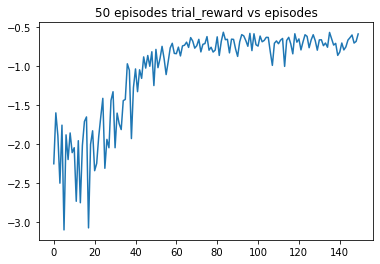

In [10]:
plt.plot(trial_scores_ddqn)
plt.title('50 episodes trial_reward vs episodes')


... loading best models ...


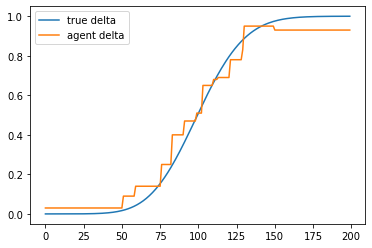

In [15]:
'''load the best model and check the delta(hedging position)'''
ddqn_agent.load_models()

t_delta = []
agent_delta = []
for i in range(400, 600):
    St = i/10
    t_delta.append(delta(St, K, rf, sigma, T))
    observation = [St,T]
    agent_delta.append(ddqn_agent.final_action(observation)/100)
plt.plot(t_delta, label = 'true delta')
plt.plot(agent_delta, label = 'agent delta')
plt.legend(loc='upper left')    

2. Traning for DDPG

In [17]:
from DDPG import DDPGAgent
ddpg_agent = DDPGAgent(LR = 0.00025, theta = 0.00025, input_dims=[2], tau=0.001, gamma = 1, batch_size=64, fc1_dims=400, fc2_dims=300 )

In [18]:
best_trial_50 = -9999

trail_scores_ddpg = []
for i in range(15000):
    
    env = HedgingEnv_Continuous(S, K, T, sigma, rf)
    done = False
    score = 0
    state = [S, T]
    while not done:
        action = ddpg_agent.choose_action(state)
        next_state, reward, done = env.step(action)
        ddpg_agent.remember(state, action, reward, next_state, int(done))
        ddpg_agent.learn()
        score += reward
        state = next_state
    
    #score_history.append(score)
    if i % 100 == 0:
        trial_50 = episodes_50_return_continuous(ddpg_agent, S, K, T, sigma, rf)
        print('episode ', i, 'score %.2f' % score,
              'trail 50 games avergae %.2f' % trial_50)
        
        if trial_50 > best_trial_50:
            best_trial_50 = trial_50
            ddpg_agent.save_models()
        
        trail_scores_ddpg.append(trial_50)
        if abs(trial_50) < 0.45:
            print('Finish training early!!')
            break

episode  0 score -6.40 trail 50 games avergae -3.22
... saving best models ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
episode  100 score -2.12 trail 50 games avergae -1.70
... saving best models ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
episode  200 score -1.22 trail 50 games avergae -1.77
episode  300 score -0.86 trail 50 games avergae -1.74
episode  400 score -1.54 trail 50 games avergae -1.74
episode  500 score -1.34 trail 50 games avergae -1.69
... saving best models ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
episode  600 score -0.96 trail 50 games avergae -1.68
... saving best models ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
episode  700 score -1.02 trail 50 games avergae -1.89
episode  800 score -1.17 trail 50 games averga

episode  11400 score -1.11 trail 50 games avergae -0.80
episode  11500 score -0.60 trail 50 games avergae -0.53
episode  11600 score -1.67 trail 50 games avergae -0.52
episode  11700 score -1.16 trail 50 games avergae -0.60
episode  11800 score -0.44 trail 50 games avergae -0.55
episode  11900 score -1.05 trail 50 games avergae -0.55
episode  12000 score -1.54 trail 50 games avergae -0.58
episode  12100 score -0.61 trail 50 games avergae -0.54
episode  12200 score -0.71 trail 50 games avergae -0.57
episode  12300 score -0.79 trail 50 games avergae -0.87
episode  12400 score -2.93 trail 50 games avergae -0.59
episode  12500 score -2.84 trail 50 games avergae -0.61
episode  12600 score -0.75 trail 50 games avergae -0.52
episode  12700 score -1.34 trail 50 games avergae -0.46
episode  12800 score -0.97 trail 50 games avergae -0.54
episode  12900 score -4.59 trail 50 games avergae -0.56
episode  13000 score -0.40 trail 50 games avergae -0.51
episode  13100 score -3.13 trail 50 games averga

In [20]:
''' save the final model and trial score records'''
torch.save(ddpg_agent, r'./final_ddpg_agent.pth')
open_file = open('./trial_scores_ddpg_100.pkl', "wb")
pickle.dump(trail_scores_ddpg, open_file)
open_file.close()

... loading best models ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...


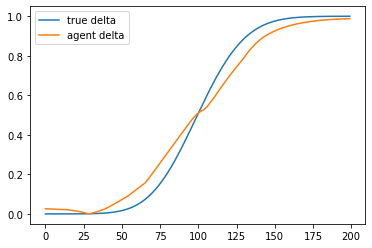

In [23]:
'''load the best model and check the delta(hedging position)'''
ddpg_agent.load_models()

t_delta = []
agent_delta = []
for i in range(400, 600):
    St = i/10
    t_delta.append(delta(St, K, rf, sigma, T))
    observation = [St,T]
    agent_delta.append(ddpg_agent.final_action(observation))
plt.plot(t_delta, label = 'true delta')
plt.plot(agent_delta, label = 'agent delta')
plt.legend(loc='upper left')   

Text(0.5, 1.0, '50 episodes trial_reward vs episodes')

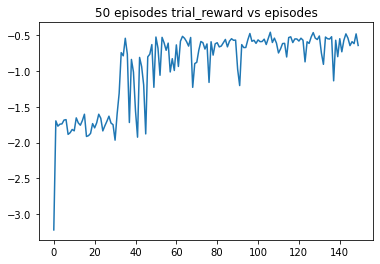

In [29]:
plt.plot(trail_scores_ddpg)
plt.title('50 episodes trial_reward vs episodes')


Text(0.5, 1.0, '50 episodes trial_reward vs episodes')

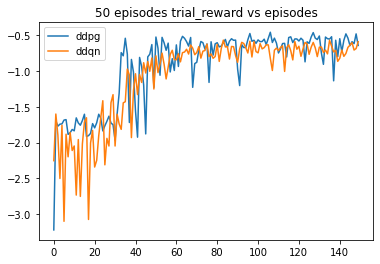

In [32]:
plt.plot(trail_scores_ddpg, label = 'ddpg')
plt.plot(trial_scores_ddqn, label = 'ddqn')
plt.legend(loc = 'upper left')
plt.title('50 episodes trial_reward vs episodes')
